# HW1 : Regression, Cross-Validation, and  Regularization

In [2]:
import os
import numpy as np
import warnings

import sklearn.preprocessing
import sklearn.pipeline
import sklearn.linear_model
import sklearn.neighbors
import sklearn.model_selection


In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

# Set random seed to make all computations reproducible

In [4]:
SEED = 12345

# Load the dataset

Predefined 'x' and 'y' arrays for train/valid/test

In [5]:
DATA_DIR = 'data_auto'

In [6]:
x_tr_MF = np.loadtxt(os.path.join(DATA_DIR, 'x_train.csv'), delimiter=',', skiprows=1)
x_va_NF = np.loadtxt(os.path.join(DATA_DIR, 'x_valid.csv'), delimiter=',', skiprows=1)
x_te_PF = np.loadtxt(os.path.join(DATA_DIR, 'x_test.csv'), delimiter=',', skiprows=1)

In [7]:
y_tr_M = np.loadtxt(os.path.join(DATA_DIR, 'y_train.csv'), delimiter=',', skiprows=1)
y_va_N = np.loadtxt(os.path.join(DATA_DIR, 'y_valid.csv'), delimiter=',', skiprows=1)
y_te_P = np.loadtxt(os.path.join(DATA_DIR, 'y_test.csv'), delimiter=',', skiprows=1)

# Load completed code

In [8]:
from cross_validation import train_models_and_calc_scores_for_n_fold_cv
from performance_metrics import calc_mean_squared_error

# Define useful plotting functions

In [8]:
def plot_train_and_valid_error_vs_degree(
        degree_list, err_tr_list=None, err_va_list=None):
    ''' Plot provided errors versus degrees on a new figure
    '''
    if err_va_list is not None:
        plt.plot(degree_list, err_va_list, 'rs-', label='valid');
    if err_tr_list is not None:
        plt.plot(degree_list, err_tr_list, 'bd:', label='train');
    plt.ylim([0, 74]); # Do NOT change this! Helps all reports look the same.
    plt.legend(loc='upper right'); # Always include a legend

# Define methods for building pipelines

Remember, we discussed pipelines in the lab from day04 on "Feature Engineering"

In [9]:
def make_poly_linear_regr_pipeline(degree=1):
    pipeline = sklearn.pipeline.Pipeline(
        steps=[
         ('rescaler', sklearn.preprocessing.MinMaxScaler()),
         ('poly_transformer', sklearn.preprocessing.PolynomialFeatures(degree=degree, include_bias=False)),
         ('linear_regr', sklearn.linear_model.LinearRegression()),
        ])

    # Return the constructed pipeline
    # We can treat it as if it has a 'regression' API
    # e.g. a fit and a predict method
    return pipeline

In [10]:
def make_poly_ridge_regr_pipeline(degree=1, alpha=1.0):
    pipeline = sklearn.pipeline.Pipeline(
        steps=[
         ('rescaler', sklearn.preprocessing.MinMaxScaler()),
         ('poly_transformer', sklearn.preprocessing.PolynomialFeatures(degree=degree, include_bias=False)),
         ('ridge_regr', sklearn.linear_model.Ridge(alpha=alpha)),
        ])
    
    # Return the constructed pipeline
    # We can treat it as if it has a 'regression' API
    # e.g. a fit and a predict method
    return pipeline

# Problem 1: Polynomial Degree Selection on Fixed Validation Set

In [11]:
degree_list = [1, 2, 3, 4, 5, 6, 7]
fv_err_tr_list = []
fv_err_va_list = []

pipeline_list = []
for degree in degree_list:

    # TODO create a pipeline using features with current degree value
    pipeline_1 = make_poly_linear_regr_pipeline(degree)
    

    # TODO train this pipeline on provided training data
    pipeline_1.fit(x_tr_MF, y_tr_M)
    
    # Compute training error
    
    yhat_tr_M = pipeline_1.predict(x_tr_MF)  # TODO fixme
    err_tr = calc_mean_squared_error(y_tr_M, yhat_tr_M) # TODO fixme
    
    # Compute validation error
    yhat_va_N = pipeline_1.predict(x_va_NF)  # TODO fixme
    err_va = calc_mean_squared_error(y_va_N, yhat_va_N) # TODO fixme

    fv_err_tr_list.append(err_tr)
    fv_err_va_list.append(err_va)

### Figure 1: Error vs degree

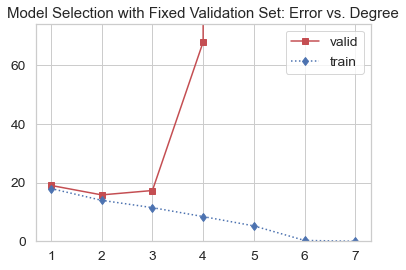

In [12]:
plot_train_and_valid_error_vs_degree(degree_list, fv_err_tr_list, fv_err_va_list);
plt.title('Model Selection with Fixed Validation Set: Error vs. Degree');
plt.savefig('figure1-err_vs_degree-fv.pdf')

### Prediction 1: Score on the test set using the chosen model

In [64]:
#score on test set using degree 2 as the chosen model
pipeline_1 = make_poly_linear_regr_pipeline(degree=2)
pipeline_1.fit(x_tr_MF, y_tr_M)
yhat_test_P = pipeline_1.predict(x_te_PF)  # TODO fixme
err_test = calc_mean_squared_error(y_te_P, yhat_test_P) # TODO fixme

#printint out intercept coefficent and min and max weights
pipeline_degree6 = make_poly_linear_regr_pipeline(degree=6)
pipeline_degree6.fit(x_tr_MF, y_tr_M)
print("intercept: ", pipeline_degree6.named_steps["linear_regr"].intercept_)
print("min: ", min(pipeline_degree6.named_steps["linear_regr"].coef_))
print("max: ", max(pipeline_degree6.named_steps["linear_regr"].coef_))

intercept:  12901018868.880665
min:  -9693867535991.963
max:  5546360787986.932


In [65]:
print("Selected Parameters:")
print("Degree 2")
print("Fixed validation set estimate of heldout error:")
print(fv_err_va_list[1])
print("Error on the test-set:")
print(err_test)
rmse = np.sqrt(err_test)
print("RMSE: ", rmse)

Selected Parameters:
Degree 2 and:  [-40.72382583  -7.196857   -11.00147358 -11.09712087  -4.44953082
   8.80431327  26.38475047   8.98426879 -31.76874156  27.17475693
  13.42846245  21.76463227 -80.86066484  52.64870837]
Fixed validation set estimate of heldout error:
15.793274734511765
Error on the test-set:
15.932092578370812
RMSE:  3.9915025464567617


# Problem 2: Cross Validation for Polynomial Feature Regression

In [53]:
x_trva_LF = np.concatenate((x_tr_MF, x_va_NF))  # TODO fix concat your train and validation set x values

y_trva_L = np.concatenate((y_tr_M, y_va_N))   # TODO fix concat your train and validation set y values


In [54]:
K = 10 # num folds

degree_list = [1, 2, 3, 4, 5, 6, 7]
cv_err_tr_list = []
cv_err_va_list = []

for degree in degree_list:

    # TODO create a pipeline using features with current degree value
    test_pipeline = make_poly_linear_regr_pipeline(degree)
    # TODO call your function to train a separate model for each fold and return train and valid errors
    # Don't forget to pass random_state = SEED (where SEED is defined above) so its reproducible
    #  = train_models_and_calc_scores_for_n_fold_cv() # TODO

    tr_error_K, valid_error_K = (train_models_and_calc_scores_for_n_fold_cv(test_pipeline, x_trva_LF, y_trva_L, K, np.random.RandomState(SEED)))
    
    err_tr = np.average(tr_error_K) # TODO fixme, compute average error across all train folds
    err_va = np.average(valid_error_K) # TODO fixme, compute average error across all heldout folds

    cv_err_tr_list.append(err_tr)
    cv_err_va_list.append(err_va)

[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  12,  13,  14,
        15,  16,  17,  18,  19,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  31,  32,  34,  36,  37,  38,  39,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  86,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98, 100, 102, 104, 105, 106, 107,
       108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 129, 130, 131, 133, 134, 135, 136,
       137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 149, 150,
       151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 165, 166,
       167, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
       194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 2

 25.55709373 21.55545081 22.77681253 19.99731432 27.15626025]
[24.00634971 18.44211735 21.67802309 22.99483189 22.53610377 20.43670174
 17.33465037 17.22115698 21.48274358 35.18365249 29.46990634 31.56648248
 19.53336165 15.64967781  9.69968191 30.65685329 27.87427245 27.63413816
 13.93656262 13.01607748 23.44111038 16.31116894 18.2411103  28.46921274
 13.62159951 21.30677056 32.22725484 35.14803664 29.54091739]
FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 [1.050e+02 3.897e+03 6.000e+00 2.500e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[22.93529518 13.61256916 17.28967386  9.62626388 19.44747809 15.04073401
 27.82523998 31.64828534 27.48519688 27.79090448 19.61412891 27.90046907
 27.33341279 15.78224312 28.3098713  32.88629449 30.51453643 21.44600905
 15.86003118 26.64211365 31.82936493 14.08059536 25.57557229 23.70199491
 31.50453637 22.66765

 26.28894993 17.08536464 22.74238034 19.3324406  26.54453585]
[26.2155188  22.35538312 11.91793857 15.41101744 26.08213474 19.2328349
 27.92036171 35.26969544 12.9075352  21.74391053 27.7854812  15.30814888
 31.47281968 26.78454094 31.6682983  32.54848938 34.51611752  0.15455278
 17.30960466 23.33383135 19.80450283 32.48617037 30.94238331 17.52747234
 33.66433999 32.95951956 31.64399262 11.48523684 23.8388912 ]
FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[26.12728729 12.77164513 13.88005746 15.24801042  7.89352045 20.84375575
 14.87749896 27.00674296 27.65297183 28.17682503 17.49293936 28.35769773
 26.26529925 16.85435955 33.32865226 32.05239803 30.65810548 21.83750689
 15.54924987 27.787055   32.13382407 12.83559627 27.06701062 24.20527347
 32.63031789 29.906123

 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[12.63842459 14.07094982  8.95199181 19.34060564 33.87812487 26.40209605
 26.49825454 16.22075775 26.38559599 25.93556783 14.43422994 36.4
 34.56702477 31.39152962 23.42755826 15.31173197 28.64704612 10.81849686
 21.19635334 25.80166769 32.5421362  30.89141889 31.31098446 22.96620009
 25.61555227 15.45950525 18.23890682 13.9535585  32.3867119  31.17837756
 24.78311425 40.47048444 29.61248752 19.70362568 34.02886713 28.07418915
 14.5536141  20.33620836 13.67805531 26.76545961 29.00379929 15.30795941
 16.77513705 20.23147761 14.85810637 16.35023707 33.43024168 33.50381506
 14.45588719 26.2089398  33.10238135 17.92441417 26.48771134 37.23544565
 33.18795911 13.94068783 12.46304381 35.39700349 16.53130011 30.74112715
 14.2144962  25.80919742 32.20048267 25.88105111 37.73614856 15.82520346
 21.11867467 15.90400606 11.61330116 34.1360349  19.0636663  26.73102028
 30.71975607 32.23131547 32.14174576 24.27230783 18.99224502 15.70871202
 14.4352202  1

  8.93666992e+01]
FOLD:  [[ 115. 2595.    6.  173.]
 [ 180. 4380.    8.  350.]
 [ 150. 4457.    8.  318.]
 ...
 [ 120. 3410.    6.  258.]
 [  88. 3139.    6.  250.]
 [ 100. 3288.    6.  232.]]
[28.84606934 14.72692871 15.39099121 16.97546387  9.02380371 14.30505371
 28.01831055 29.44055176 27.83251953 28.03845215 19.58337402 26.41088867
 15.18005371 36.39941406 34.69842529 31.42419434 23.91833496 14.75817871
 27.02380371 34.35101318 21.17907715 19.98376465 33.76452637 30.72711182
 30.52307129 24.92614746 27.84692383 16.21520996 19.1541748  16.95349121
 13.41833496 31.60864258 30.74035645 22.27020264 20.30358887 28.81225586
 20.73461914 28.35351562 13.98474121 18.41589355 14.87145996 13.66442871
 24.95483398 28.48120117 16.20983887 17.73474121 19.83825684 14.93005371
 15.06677246 33.70581055 34.31591797 16.31286621 26.20397949 19.5447998
 18.06774902 27.24841309 26.42211914 33.78765869 12.87927246 10.68005371
 37.84411621 14.19177246 30.9465332  12.96130371 27.36206055 25.70495605
 15.5

 26.09013367 18.31376648 20.69816589 17.61784363 26.09339905]
[ 2.64812317e+01  3.70972137e+01  4.09117844e+02  3.26276093e+01
  8.20948410e+02  2.08351288e+01  2.79113617e+01  3.81307983e+01
  1.37706757e+01  1.19269089e+02  2.66026764e+01 -1.65185379e+02
  3.15967255e+01  2.53828278e+01  2.20545349e+01  3.37179871e+01
  5.15441437e+01 -3.93021419e+03 -3.17639923e+01  5.66112717e+02
  1.56246262e+02  3.53643646e+01  3.53963165e+01  1.29837082e+02
  2.56886444e+01  3.56780548e+01  2.84530334e+01  1.11317679e+10
  1.91674347e+01]
FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[28.78771973 16.60412598 13.80725098 15.93029785  8.79943848 21.10412598
 14.16662598 25.06689453 26.54125977 30.03222656 18.4185791  28.64331055
 22.52355957 14.97131348 36.38513184 38.32995605

 25.52062416 18.01395988 20.79644585 18.01339531 26.635849  ]
[-1.25372203e+03 -7.81576590e+03 -1.43148530e+03 -7.98614751e+05
 -1.22110233e+02 -1.06122943e+03 -7.00297132e+03 -3.72612386e+05
 -4.90829493e+05  5.59740305e+01  2.79725418e+01  3.12342739e+00
  1.54328085e+04 -8.46161557e+05  5.25351162e+09  1.95576744e+01
  1.55815655e+02 -1.18489313e+09 -3.46014334e+06 -4.29691243e+06
  1.11440346e+06  1.56511211e+01 -5.01531053e+04  5.05193691e+01
 -1.27844271e+07  2.80710086e+04  2.80993280e+01  7.07904768e+01
  1.66903896e+01]
FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 [1.050e+02 3.897e+03 6.000e+00 2.500e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[28.79991955 13.92945141 16.05339855  9.00049633 21.05258983 14.23963207
 27.67604679 29.87853378 26.54872078 32.06649917 18.35700268 28.01679081
 24.19815391 14.96912426 36.40244335 44.56380695

### Figure 2: Error vs degree

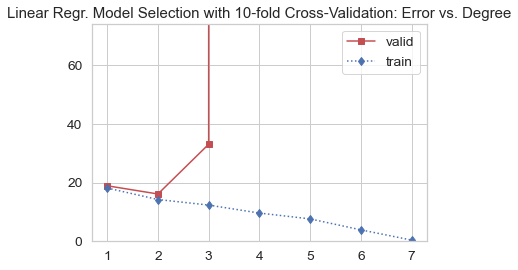

In [55]:
plot_train_and_valid_error_vs_degree(degree_list, cv_err_tr_list, cv_err_va_list)
plt.title('Linear Regr. Model Selection with 10-fold Cross-Validation: Error vs. Degree');
plt.savefig('figure2-err_vs_degree-cv-seed=%d.pdf' % SEED)

### Prediction 2: Score on the test set using the chosen model

Use the chosen hyperparameters, retrain ONE model on the FULL train+valid set.
Then make predictions on the heldout test set.

In [56]:
# TODO compute score on test set for later

pipeline_2 = make_poly_linear_regr_pipeline(2)
pipeline_2.fit(x_trva_LF, y_trva_L)
yhat_test_poly = pipeline_2.predict(x_te_PF)
err_test = calc_mean_squared_error(y_te_P, yhat_test_poly)


In [57]:
print("Selected Parameters:")
print("Degree 2")
print("10-fold CV estimate of heldout error:")
print(cv_err_va_list[1])
print("Error on the test-set:")
print(err_test)

rmse = np.sqrt(err_test)
print("RMSE: ", rmse)

Selected Parameters:
Degree 2, and  [-32.33395249   0.31147353 -15.62249275 -19.58991831  -2.42133875
 -24.43662864  41.26543755   6.48079562 -33.64983326  15.88419524
  52.27946183  29.99790792 -97.1502741   51.25489631]
10-fold CV estimate of heldout error:
16.099534697559545
Error on the test-set:
15.334679184359443
RMSE:  3.9159518873907837


# Problem 3: Cross Validation for Ridge Regression

In [58]:
alpha_grid = np.logspace(-6, 6, 13) # 10^-6, 10^-5, 10^-4, ... 10^-1, 10^0, 10^1, ... 10^6

degree_list = [1, 2, 3, 4, 5, 6, 7]

K = 10 # num folds
ridge_cv_err_tr_list = []
ridge_cv_err_va_list = []

ridge_param_list = list()

for degree in degree_list:
    for alpha in alpha_grid:
        ridge_param_list.append(dict(alpha=alpha, degree=degree))
        # TODO create a pipeline using features with current degree value
        ridge_pipeline = make_poly_ridge_regr_pipeline(degree, alpha)
        # TODO call your function to train a separate model for each fold and return train and valid errors
        # Don't forget to pass random_state = SEED (where SEED is defined above) so its reproducible
        tr_error_K, valid_error_K = train_models_and_calc_scores_for_n_fold_cv(ridge_pipeline, x_trva_LF, y_trva_L, K, np.random.RandomState(SEED)) # TODO
    
        err_tr = np.average(tr_error_K) # TODO fixme, compute average error across all train folds
        err_va = np.average(valid_error_K) # TODO fixme, compute average error across all heldout folds
    
        ridge_cv_err_tr_list.append(err_tr)
        ridge_cv_err_va_list.append(err_va)

[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  12,  13,  14,
        15,  16,  17,  18,  19,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  31,  32,  34,  36,  37,  38,  39,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  86,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98, 100, 102, 104, 105, 106, 107,
       108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 129, 130, 131, 133, 134, 135, 136,
       137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 149, 150,
       151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 165, 166,
       167, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
       194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 2

 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[25.2653853  12.05565798 12.88711589 18.54023264 10.37068458 22.73011216
 14.64089925 28.32920059 29.45861274 28.00768686 28.51779005 20.56046338
 29.78179697 28.372658   14.42904761 25.94760281 29.60053045 16.2975201
 24.94771478 30.46040187 10.49791446 26.27098368 24.17792081 30.931369
 29.62154938 30.74564614 23.7989526  26.71005269 14.78659101 22.49396377
 18.02701283 13.34284318 30.25704743 29.92218198 28.68446004 25.34365751
 30.26769408 29.74818905 24.29931441 31.11779551 28.43775849 11.09006619
 23.48192805 13.40445214 13.98677196 29.69303612 21.80344163 21.22563989
 15.0229264  15.51847581 31.32001906 30.55756439 13.20844971 20.21812745
 32.27244299 19.61726654 26.76060787 31.64913825 27.26084553 30.54528621
 13.02706501  9.25205986 30.00493165 12.79855476 27.26853051 32.34834992
 28.46169069 31.95606001 16.82877547 23.73268146 24.99280513  8.05837768
 31.56878724 24.23979565 29.37740723 29.9952154  30.3598176  30.11691132
 27.962758

 26.20296168 23.4334403  23.99184233 22.05980538 27.06132141]
[ 8.46417715 11.39615011 32.3159965  30.92919822 24.20123148 14.4021511
 33.79496465 25.83353257 26.98704941 19.28343303 13.26928951 29.441257
 22.14121627 11.37360794 14.53958104  9.13583455 16.78906444 21.44656655
 15.22125637 25.37365891 27.12237113 11.17159779 30.70974157 22.77767433
 14.42829564 30.44629709 26.2102412  30.77830922 21.10611823]
FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.050e+02 3.897e+03 6.000e+00 2.500e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[25.50691784 11.92107478 18.42381402 22.62651722 14.798522   28.23872586
 29.49071521 27.72565073 28.22259689 20.42022752 29.57085273 14.79178543
 26.32153743 32.04608605 29.53384515 20.96654796 16.4124138  24.75258547
 30.45454086  9.59368886 26.65258463 31.00181966 29.53477118 30.77435928
 26.34615163 14.72771903

 26.24867536 23.24392126 24.18324833 22.12524564 26.95768859]
[30.50637215 21.72889095 22.74441553 16.85953083 25.20213171 25.17009266
 28.72467985 26.19303662 14.87177484 29.56842057 18.81900083 18.18801642
 21.65568409 21.36656241 25.08869077 32.92953089 15.1842332  21.76219611
 31.46929592 25.25088512  8.41714382 27.01982817 29.88855475 28.08560707
 28.27095255 28.96284691 20.56337525 14.23640472  9.81969969]
FOLD:  [[ 115. 2595.    6.  173.]
 [ 180. 4380.    8.  350.]
 [ 150. 4457.    8.  318.]
 ...
 [ 120. 3410.    6.  258.]
 [  88. 3139.    6.  250.]
 [ 100. 3288.    6.  232.]]
[25.3365203  11.62618438 12.88928485 18.31662625  9.82293456 14.70934315
 27.89316501 29.31881542 27.52637198 28.05575182 20.49176565 27.89337052
 14.74571438 26.14674403 31.98564553 29.36966753 21.35131248 16.42856719
 24.48476121 30.32479125 26.50563595 24.16313896 30.81691237 29.35582529
 30.55087526 23.81337239 26.02715433 14.88482801 22.62384843 18.22341693
 13.13036494 30.15597566 29.66980358 28.1198

 32.36514123 23.91412253 31.33259632  8.85115342 24.50843189]
FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[25.46404114 11.6939481  12.82025187 18.3884594   9.52580528 22.91221635
 14.76411114 27.99981468 29.44236046 27.76372859 28.32911702 20.70183483
 29.59929513 28.00558713 14.68465856 26.0779751  32.25375751 29.55731405
 21.44639288 16.60027737 24.53112924 30.52092781  9.91487877 24.12437234
 30.97574157 29.55235328 30.7169129  23.81038487 15.127151   22.86598702
 18.51721338 13.27961995 29.88203017 25.06240407 30.49100133 29.58315942
 23.4449717  31.30256373 28.23680693 23.8550401  13.29491249 13.98955121
 29.182395   29.5114137  22.35509454 18.1895932  21.29768226 15.29352984
 16.02695105 31.4065137  30.62862085 13.30377888 28.05667808 20.21273818
 32.610610

       289, 290, 291])]
(292, 4)
[array([222, 168,  99,  33,  30, 164, 163,  55,  52, 290, 162, 246,  73,
       101, 132,  87,  85,  53, 128,  40, 248, 110, 220,  20,  35,  11,
        10, 148, 103,  54]), array([100, 175,  67, 113, 234, 213, 269,  16, 184, 237, 141, 179, 176,
       284, 227, 165,  50, 275,  47, 271, 145, 221, 279,  68,  57, 211,
       159, 106,  18, 277]), array([256,  75,  97, 127, 205, 161, 186, 112,  71, 160, 212, 150, 147,
       282, 258,  70, 261, 217, 207, 134, 120, 130, 228, 196, 260, 283,
       274,   9, 240]), array([229, 241, 249, 259, 115,  44, 183,  89, 214, 215,  39,  27, 245,
        14, 156,  17, 167,  15, 225, 152,  49,  19, 188,  42,  66,  31,
       242, 266,  48]), array([169, 117, 180,  95, 244, 191, 230, 174, 144, 122,  56,  26, 140,
         1,  93, 104, 268, 253, 281, 206,  92, 181,  25, 187, 139, 198,
       239,  94, 151]), array([ 61, 219,  78, 109,  24,  51, 157, 265,   2, 126, 203, 182,  84,
        13, 173, 170, 131,   4, 135,  28,  9

 26.92320087 22.50563908 23.41152961 22.12341617 27.14358018]
[12.36510961 14.17476776 30.25682317 29.45202131 22.93490398 15.99857179
 30.96747026 24.07642484 27.54957226 20.64049335 14.87707845 28.69561362
 22.33497532 13.90473474 15.78933114 11.9552821  16.72552126 21.60754237
 15.66205252 26.25664555 27.46806343 13.20309602 29.52569288 22.09007584
 14.96744652 29.25232652 27.20813445 29.58178    21.73326131]
FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.050e+02 3.897e+03 6.000e+00 2.500e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[23.94914867 13.88225699 20.46227075 22.3259607  15.6945265  28.14184405
 28.98151263 27.72246758 27.93143076 21.38188575 28.5833933  16.05009156
 26.35089665 30.0897685  28.84670253 19.44424371 16.37315929 26.57258839
 29.35245301 11.77481321 24.66810118 29.66485843 28.80465858 29.47625566
 26.93221115 15.48935

 22.37714091 25.34685329 23.44245882 22.88135727 25.41416943]
[25.58278414 25.74243886 18.94096812 26.3300429  25.73241946 25.29828834
 23.0000071  23.95561528 20.70960513 18.52674412 26.53272553 20.51755093
 19.70882498 25.90573773 25.01670806 23.36554555 26.55768127 26.41525964
 25.59302957 23.46555204 26.15033182 25.7246469  20.11998688 26.5512788
 20.22407712 25.30505022 26.29327505 25.31980301 26.11999562]
[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  12,  13,  14,
        15,  16,  17,  18,  19,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  31,  32,  34,  36,  37,  38,  39,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  86,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98, 100, 102, 104, 105, 106, 107,
       108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       1

[23.57145582 23.4911802  23.54717503 23.55954933 23.50459326 23.60982031
 23.61607843 23.60640417 23.60774881 23.55329452 23.61229702 23.50790122
 23.59409575 23.62334595 23.61475983 23.53205875 23.50896013 23.59921383
 23.61837881 23.47411768 23.5768113  23.62069131 23.61437505 23.61922153
 23.60072365 23.50259017 23.56109596 23.5135191  23.49627496 23.61771113
 23.61526736 23.60812469 23.5874212  23.62093852 23.61450017 23.59508598
 23.62067895 23.60928956 23.4825084  23.56256577 23.49587012 23.50426673
 23.61100896 23.6146543  23.55952069 23.51544268 23.50673477 23.49871968
 23.6217158  23.61863493 23.49763603 23.60851184 23.55466123 23.6241628
 23.55364459 23.62462543 23.60659114 23.61837567 23.49544256 23.47272596
 23.62200094 23.50616638 23.61614354 23.49553451 23.60406999 23.62639149
 23.60927558 23.62613336 23.51175829 23.56954403 23.56654846 23.56456352
 23.61108579 23.61611793 23.61718789 23.60714792 23.50894095 23.5049981
 23.51576575 23.61533387 23.60575858 23.50483657 23.6

       289, 290, 291])]
(292, 4)
[array([222, 168,  99,  33,  30, 164, 163,  55,  52, 290, 162, 246,  73,
       101, 132,  87,  85,  53, 128,  40, 248, 110, 220,  20,  35,  11,
        10, 148, 103,  54]), array([100, 175,  67, 113, 234, 213, 269,  16, 184, 237, 141, 179, 176,
       284, 227, 165,  50, 275,  47, 271, 145, 221, 279,  68,  57, 211,
       159, 106,  18, 277]), array([256,  75,  97, 127, 205, 161, 186, 112,  71, 160, 212, 150, 147,
       282, 258,  70, 261, 217, 207, 134, 120, 130, 228, 196, 260, 283,
       274,   9, 240]), array([229, 241, 249, 259, 115,  44, 183,  89, 214, 215,  39,  27, 245,
        14, 156,  17, 167,  15, 225, 152,  49,  19, 188,  42,  66,  31,
       242, 266,  48]), array([169, 117, 180,  95, 244, 191, 230, 174, 144, 122,  56,  26, 140,
         1,  93, 104, 268, 253, 281, 206,  92, 181,  25, 187, 139, 198,
       239,  94, 151]), array([ 61, 219,  78, 109,  24,  51, 157, 265,   2, 126, 203, 182,  84,
        13, 173, 170, 131,   4, 135,  28,  9

FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[22.85880645 12.70861076 13.72114942 17.05018966  9.42136584 19.29302962
 15.32860374 28.49423153 32.07351574 27.67007562 27.91661117 19.33245083
 28.37733248 28.07547909 15.67996862 28.47543955 30.86219396 16.05955337
 26.52855843 32.11422913 14.92507216 25.08608875 23.81453384 32.92391297
 30.46799848 31.99729745 22.77103146 25.14358181 15.36631339 20.74786456
 16.00642395 14.12243392 32.24101396 30.62551335 26.97298641 24.4450335
 34.89144338 29.99331794 21.33290505 32.79344025 28.73550207 13.48329985
 20.02738466 14.07387622 15.02298627 30.14755929 22.14654069 19.10728615
 15.69346343 15.75228944 33.00578807 32.13731401 14.41269464 18.76939768
 33.10198895 18.56502767 26.00981022 35.03820582 27.30625422 31.90603642


 26.00641126 20.0959663  22.44963417 19.54812091 27.492731  ]
[18.37592453 34.30258321 11.32473333 32.22029892 15.16980824 33.45092212
 25.57246257 18.52234381 30.80359602 20.0251301  26.85228213 26.43798717
 16.93526451 32.73661598 17.29899596 18.45663999 22.78490667 30.48389179
 19.85226223 25.19488995 13.91203713 30.42429581 24.77750439 17.5075704
 30.32905526 13.55759005 31.86027126 27.6727302  13.73807133]
FOLD:  [[1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 [1.930e+02 4.732e+03 8.000e+00 3.040e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[12.80164013 13.86722142  9.10460943 19.23587816 32.33365276 27.26083379
 27.45559459 19.67242053 27.82719234 27.62801337 15.96978919 29.22253714
 32.97451603 30.84310851 20.6771417  16.15345188 27.04526241 15.1502134
 25.14834126 23.453659   32.99982387 30.35333875 31.89915781 22.55223841
 24.49363273 15.6006584

       289, 290, 291])]
(292, 4)
[array([222, 168,  99,  33,  30, 164, 163,  55,  52, 290, 162, 246,  73,
       101, 132,  87,  85,  53, 128,  40, 248, 110, 220,  20,  35,  11,
        10, 148, 103,  54]), array([100, 175,  67, 113, 234, 213, 269,  16, 184, 237, 141, 179, 176,
       284, 227, 165,  50, 275,  47, 271, 145, 221, 279,  68,  57, 211,
       159, 106,  18, 277]), array([256,  75,  97, 127, 205, 161, 186, 112,  71, 160, 212, 150, 147,
       282, 258,  70, 261, 217, 207, 134, 120, 130, 228, 196, 260, 283,
       274,   9, 240]), array([229, 241, 249, 259, 115,  44, 183,  89, 214, 215,  39,  27, 245,
        14, 156,  17, 167,  15, 225, 152,  49,  19, 188,  42,  66,  31,
       242, 266,  48]), array([169, 117, 180,  95, 244, 191, 230, 174, 144, 122,  56,  26, 140,
         1,  93, 104, 268, 253, 281, 206,  92, 181,  25, 187, 139, 198,
       239,  94, 151]), array([ 61, 219,  78, 109,  24,  51, 157, 265,   2, 126, 203, 182,  84,
        13, 173, 170, 131,   4, 135,  28,  9

 25.41715481 20.08153623 22.97769119 19.68690376 26.03481583]
[25.64239225 22.71156936 10.96984007 16.05534949 21.87561816 19.08116315
 27.65070702 34.6579267  14.29213821 21.85408218 28.06091683 19.78765209
 31.45281343 27.67581918 32.97860869 32.64722941 36.01273784 10.78076373
 16.85645266 21.76923353 17.19221454 32.74971356 31.1021389  21.99757814
 33.3732283  33.18918439 31.74606263 23.71520027 24.97994241]
FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[21.98467317 13.24008583 14.02982036 17.08831952 10.66985245 19.54708838
 15.23568793 27.97763474 27.34422563 27.58342194 18.86559868 27.75588889
 27.38092219 15.45774369 28.69369129 33.05665011 30.75045578 19.97203231
 15.99213953 26.80222967 32.08623695 14.35253981 23.92620813 21.54367449
 32.57449681 30.27627

 27.82476858 28.8324738  19.38447136 14.74621591 13.21325828]
FOLD:  [[ 115. 2595.    6.  173.]
 [ 180. 4380.    8.  350.]
 [ 150. 4457.    8.  318.]
 ...
 [ 120. 3410.    6.  258.]
 [  88. 3139.    6.  250.]
 [ 100. 3288.    6.  232.]]
[22.65413974 12.99877912 14.04062243 17.32760596 11.38676809 14.97105389
 27.84450197 31.09337654 26.98638247 27.42509896 19.11848161 27.51367983
 15.49929901 27.49452329 33.44610147 30.27621273 20.71208371 15.82595631
 25.29741641 31.7076903  24.34738355 21.72280732 32.37358418 29.9833065
 31.52517554 21.61871531 24.5971109  15.29706294 21.19031608 16.69360621
 13.99383705 31.77084927 30.2797466  26.83335013 23.78894145 29.55821348
 22.27793871 28.07112376 12.91035248 21.26254619 13.89913891 14.61876002
 28.31616983 29.60030178 21.4751057  16.95091713 19.42535108 15.47425332
 15.58088274 32.72342455 31.79439489 14.33428304 26.95704931 19.09422272
 18.9588592  25.39998246 26.71832597 31.59260986 13.8390309  12.36285723
 33.28621304 15.62070179 30.382169

       289, 290, 291])]
(292, 4)
[array([222, 168,  99,  33,  30, 164, 163,  55,  52, 290, 162, 246,  73,
       101, 132,  87,  85,  53, 128,  40, 248, 110, 220,  20,  35,  11,
        10, 148, 103,  54]), array([100, 175,  67, 113, 234, 213, 269,  16, 184, 237, 141, 179, 176,
       284, 227, 165,  50, 275,  47, 271, 145, 221, 279,  68,  57, 211,
       159, 106,  18, 277]), array([256,  75,  97, 127, 205, 161, 186, 112,  71, 160, 212, 150, 147,
       282, 258,  70, 261, 217, 207, 134, 120, 130, 228, 196, 260, 283,
       274,   9, 240]), array([229, 241, 249, 259, 115,  44, 183,  89, 214, 215,  39,  27, 245,
        14, 156,  17, 167,  15, 225, 152,  49,  19, 188,  42,  66,  31,
       242, 266,  48]), array([169, 117, 180,  95, 244, 191, 230, 174, 144, 122,  56,  26, 140,
         1,  93, 104, 268, 253, 281, 206,  92, 181,  25, 187, 139, 198,
       239,  94, 151]), array([ 61, 219,  78, 109,  24,  51, 157, 265,   2, 126, 203, 182,  84,
        13, 173, 170, 131,   4, 135,  28,  9

 26.61022916 23.57152428 24.16704528 23.3718069  26.69538067]
[14.34767283 16.09322145 27.88800347 27.62117228 23.81311442 17.76290521
 28.11061691 24.53703901 26.89431987 22.38910168 16.72098053 27.34583307
 23.5035664  15.85638145 17.56760506 13.88468647 18.33881431 23.02803224
 17.39845974 26.30088566 26.85568765 15.11098695 27.65551034 23.31150034
 16.774678   27.55259676 26.75062006 27.67396013 23.13270092]
FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.050e+02 3.897e+03 6.000e+00 2.500e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[24.44229371 15.71348871 22.19893521 23.44866855 17.38736454 27.11046864
 27.44322156 26.92746528 27.01390168 22.8263366  27.27786004 17.70303573
 26.06539575 27.83558149 27.38933982 20.44812883 17.96838246 26.40102158
 27.58010116 13.54371404 24.85039986 27.69506376 27.37253927 27.62575083
 26.57868637 17.17543

 24.43062054 23.57283987 23.74204704 23.52524191 24.45020551]
[23.44225678 24.69441209 23.15120432 24.64438187 21.85025858 24.70862996
 24.73816358 23.50206461 24.65566654 23.52399249 24.49725683 24.41581845
 22.17380161 24.69964946 23.31487799 23.412594   23.96738294 24.63300362
 23.56158894 24.48696858 21.59511747 24.64456219 24.43060374 23.312128
 24.68210856 22.19972108 24.72002919 24.50190986 21.58145387]
FOLD:  [[1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 [1.930e+02 4.732e+03 8.000e+00 3.040e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[21.71871508 22.02049101 21.65543599 23.81379619 24.88465771 24.75069025
 24.77048006 23.66859508 24.83227734 24.79250451 22.28031828 24.53087664
 24.97377209 24.8677087  22.99578651 22.31433698 24.63528832 21.09350355
 24.17310589 24.02112126 24.9420109  24.86239023 24.92334953 23.99231889
 24.66223725 22.1146789

 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[23.61416103 23.65074212 23.60668671 23.86729    23.99648257 23.98038203
 23.982744   23.84987483 23.99014016 23.98541391 23.68212707 23.95391235
 24.00710515 23.99442937 23.76837393 23.68602879 23.96662278 23.53834148
 23.91056473 23.89230356 24.00332768 23.99378614 24.00108569 23.88884463
 23.96976579 23.66195483 23.87176344 23.63591076 23.99908779 23.99519097
 23.98304793 24.00377649 23.99379498 23.95805464 24.00345748 23.98538896
 23.57708726 23.8756124  23.63405815 23.98817265 23.99401933 23.86736012
 23.71031848 23.85789109 23.67781568 23.64633037 24.0047897  24.00040202
 23.64192474 23.98368629 24.00832225 23.85040103 23.97319057 24.00902601
 23.99998719 23.63249596 23.53249243 24.0053281  23.67503469 23.99644833
 23.63309534 23.97619448 24.01118    23.98500477 24.01102709 23.69639276
 23.89234491 23.88588369 23.54922926 24.00497583 23.88083274 23.98829891
 23.99640864 23.9982227  23.99724239 23.98182716 23.9634916  23.68581528
 23.670

 23.61032672 23.62394841 23.61556051 23.61290438 23.62418799]
[23.62471132 23.62521468 23.58658898 23.62692996 23.62518742 23.6237979
 23.61348727 23.61777027 23.59890307 23.58343564 23.62745699 23.59768903
 23.59222834 23.62572707 23.62279393 23.61521425 23.62751925 23.62715674
 23.62476827 23.61567453 23.62641572 23.62518461 23.5950605  23.62750353
 23.59575325 23.62380953 23.62683347 23.62386817 23.62635539]
[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  12,  13,  14,
        15,  16,  17,  18,  19,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  31,  32,  34,  36,  37,  38,  39,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  86,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98, 100, 102, 104, 105, 106, 107,
       108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       1

 26.02454147 20.19827151 21.591164   19.27847037 27.10258402]
[ 26.18055116  18.11625768  20.56309667  20.46585048  21.76807837
  20.51536908  17.8815359   16.59502551  20.68255965  34.61002686
  29.57418851  31.87454992  18.79033956  18.3701665  -44.19040516
  30.89324109  27.88157039  28.07636522  11.27392734  10.63490343
  20.36473678  16.16815193  17.73475042  28.58372625  15.49446559
  19.89273494  32.60729239  35.10451562  29.55758671]
FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 [1.050e+02 3.897e+03 6.000e+00 2.500e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[24.98559201 13.96741211 16.3131972   7.63693308 19.42024014 14.89227604
 27.30398586 32.29586111 27.51109555 27.899715   17.90641515 28.848842
 26.74799485 16.38706095 31.95236082 32.66715977 30.27909432 21.49800982
 15.49718026 27.62184601 31.70835362 12.92770098 26.98998492 24.29

FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[26.25079533 12.21482161 13.97936333 15.63907313  8.5893331  19.86780381
 14.72250818 27.50965521 33.31978041 27.51591933 27.83400225 17.84514704
 28.78354962 26.81601023 16.68123328 31.94197532 32.8419499  30.94446495
 21.69932538 15.27727361 28.39914594 32.35719494 13.05885202 25.28054497
 33.07523157 30.33459249 31.73845413 23.70414061 16.1885691  19.91008547
 15.43066882 13.24448124 30.46249435 22.77275706 38.9024469  29.42014666
 21.37208456 33.04298143 28.53886906 19.99776165 12.94982441 14.47583502
 28.43516813 29.41464337 18.91708909 16.69499059 18.89658368 15.8031605
 20.70470876 33.14082849 32.3397636  14.57438814 26.47317164 18.52098038
 32.66932543 18.15638303 25.82941019 36.72832948 26.38751818 13.15167854


 19.26922725 18.25196806 11.40553243 27.55264788 18.45059159]
FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[23.31582853 12.39260244 13.5055056  16.18397028  9.58791125 20.11112571
 14.98722807 27.90158571 32.29450071 27.66173488 27.94731649 18.64189261
 28.19384243 27.36362088 32.86110521 23.44471233 27.14126048 32.1528657
 13.92935931 24.76454633 23.16290856 32.62691835 30.36002525 22.35371293
 25.22380648 16.47368215 15.77419106 13.77970765 32.57056923 30.51813674
 26.74785758 23.87478648 36.13164525 21.21429586 33.04692436 13.06265591
 13.54796713 14.25243884 28.33610383 17.05171543 18.99917966 16.08118791
 16.8910722  32.72863735 32.17710148 14.90503537 26.72923741 18.00530531
 33.42734953 17.414932   25.90596817 35.75355756 26.72202073 31.85996232
 13.5900022

 [ 100. 3288.    6.  232.]]
[22.86088572 12.53640993 13.69917158 16.59822402 10.08285285 14.90929785
 28.05179988 31.73254579 27.14595132 27.47376272 18.50775401 27.60848775
 15.9000849  28.90654658 33.43876157 30.60627754 22.54302313 15.67313195
 26.12098675 32.02512511 24.79682235 22.55108472 32.62562392 30.21737272
 31.61270717 22.17793085 24.70355227 15.81532517 20.67149489 16.11066921
 13.80989173 32.21016762 30.45077785 26.66452438 24.77795589 29.59043748
 22.48711182 28.32764831 13.17907604 20.52037339 13.63627666 14.40813907
 28.22369887 29.66184937 20.90715698 16.94774405 18.99682652 15.72110328
 16.36131605 32.87661391 32.08735465 14.57647548 26.89506663 18.72777513
 18.53247987 25.65610582 27.05545138 31.83038882 13.63424547 13.33071678
 33.67128517 15.11457834 30.52417214 13.83915942 26.60021495 27.28796833
 15.94314941 21.12575715 11.24603087 32.73253213 28.24188191 31.26530249
 28.27835195 22.59012368 15.48857271 16.62730132 20.82133972 29.3720172
 25.98388952 14.96125603

[28.83429847 26.07851754 32.13215697 15.77574135 23.12794389 33.32952721
 26.06582836 32.42521943 16.66972754 27.67272467 13.62160084 31.77263508
 30.4395433  25.8234381  26.07500834 15.6147379  16.86915739 29.92074205
 29.06707847 23.04386886 15.25736219 14.66212152 28.33480209 15.73881129
 28.16282201 20.62747291 32.26903566 30.18007521 20.17091101 28.71482746]
FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[22.70426957 12.90090495 13.97426236 17.33667807 11.17756147 20.40839419
 14.98656199 28.19192056 30.53053789 28.00757844 19.24969228 28.89123123
 27.96938635 15.54379155 26.96342403 32.41559633 30.04841269 21.11760866
 15.9421053  25.89075712 31.09212717 13.13618692 24.18000159 21.6968928
 31.53364294 29.85870223 30.96733577 21.60963788 25.70202713 15.5205674


 27.2761092  22.74357446 23.65410748 22.31526258 27.50356203]
[27.4226462  23.60691793 10.13961845 15.23009631 23.99479481 21.96891809
 28.30991763 30.07296053 13.80363819 23.20166879 28.03965112 22.96704331
 29.25328752 28.3371821  30.13630278 29.66378846 30.51167874 12.14712348
 20.3974756  23.75572573 16.2119168  29.92112965 29.64579145 26.73593278
 29.7998379  29.91388942 29.46441636 28.4912834  27.58148798]
FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[24.37379286 13.07018318 13.73071756 20.5636885  12.02871858 22.81900777
 14.85405906 28.31195141 27.99575073 28.19013482 21.70194816 28.73408452
 28.28377534 14.84977508 26.6031516  29.96354832 28.94002832 18.80256828
 15.86321945 26.83293659 29.36157226 12.1514638  25.03959704 23.9373714
 29.60374144 28.906718

 23.11180709 27.04936308 24.65673106 23.87211219 27.12552286]
[27.26764384 27.41375726 14.2072362  27.83598906 27.40745563 27.03473861
 24.07104445 25.37219787 18.99015442 13.11822676 27.97535822 18.50625328
 16.58534104 27.54403323 26.76390466 24.66235789 27.98468724 27.88525022
 27.26979803 24.72760991 27.71823641 27.3983621  17.45625625 27.9810938
 17.77929473 27.03022562 27.80387926 27.04376461 27.69812393]
[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  12,  13,  14,
        15,  16,  17,  18,  19,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  31,  32,  34,  36,  37,  38,  39,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  86,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98, 100, 102, 104, 105, 106, 107,
       108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       1

 24.01544345 23.86718996 23.89846658 23.85808571 24.01837569]
[23.86794662 23.52358441 23.84870374 23.55296225 23.50783331 24.05606635
 24.02849141 24.04497483 24.02156227 23.4118609  23.2984451  23.87986635
 24.05236889 24.06230263 23.3682981  23.38267375 24.04247945 24.05517559
 23.37195325 23.90871707 24.06065688 24.03703475 23.88337885 23.83714807
 23.60458003 23.49457371 23.34710933 24.02653463 23.83277206]
FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[23.88703515 23.30826409 23.39155337 23.77767215 23.28701641 23.84004737
 23.43441058 24.01133488 24.02301521 24.00491646 24.00773908 23.81039705
 24.01616751 24.01059253 24.03458985 23.63922362 23.98720352 24.027004
 23.12266636 23.90611738 23.8785051  24.03052327 24.02018916 23.87340565
 23.99209078 23.4186839

FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.050e+02 3.897e+03 6.000e+00 2.500e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[23.58014853 23.51565735 23.56751101 23.57482078 23.52986852 23.59358395
 23.59486041 23.59287374 23.59319876 23.57132069 23.59415848 23.53263612
 23.58897817 23.59617517 23.59464216 23.55290964 23.534299   23.59077352
 23.59532342 23.49511975 23.58226508 23.59571653 23.59457153 23.59546032
 23.59144376 23.52812519 23.57546926 23.53856825 23.52147912 23.59520321
 23.59475061 23.59324861 23.58702995 23.59570822 23.5945826  23.58962449
 23.59573533 23.593509   23.50576275 23.57631394 23.52106938 23.52925147
 23.59390325 23.59460504 23.57446549 23.54013882 23.53194349 23.52451919
 23.59589521 23.59537145 23.52278959 23.59330928 23.57188972 23.59631203
 23.57116181 23.59635994 23.59280792 23.59532549 23.52052337 23.49304978

FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[23.61456953 23.608334   23.60923796 23.61338639 23.6081113  23.61406019
 23.60970032 23.61589991 23.6160255  23.61583009 23.61586042 23.61373927
 23.6159515  23.61589193 23.60999075 23.61545542 23.61614977 23.61600237
 23.61191434 23.61010562 23.61563929 23.6160683  23.60631155 23.61447871
 23.61610634 23.61599493 23.61608065 23.61442325 23.60952617 23.61413225
 23.61049785 23.60888787 23.61601187 23.61525902 23.61610923 23.61599495
 23.61552458 23.61610812 23.6158924  23.61420397 23.60884303 23.60965469
 23.61592772 23.61599743 23.61404428 23.61066579 23.61388814 23.60990291
 23.60914528 23.61612324 23.61607282 23.60902981 23.61587088 23.61380038
 23.61616341 23.61373756 23.61573578 23.61617035 23.615827   23.6088007


 26.0514661  20.36893448 21.75947159 26.28407912]
[28.86406152 30.54398607 14.66256837 13.44401199 16.07719155 33.16787727
 15.66038213 32.46693497 15.03573787 19.13051421 32.19484048 27.18508615
 26.00091418 26.24538063 33.32859642 16.33582875 27.29291582 33.60456081
 12.10293417 23.8456239  29.75520128 26.05521751 10.90490809 28.94303623
 30.49483645 17.73366535 27.52109633 25.96132181 15.60564203 33.10180759]
FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[24.46158772 13.40694687 14.43336674 15.95867988  8.15037714 19.74530595
 15.23764447 27.21975997 33.00182256 27.77596489 28.15538076 17.90176527
 29.235804   26.64235226 14.33040428 33.43892873 30.95137051 15.63980271
 28.07675541 32.47015574 13.2524414  24.4071675  25.30197135 32.87614495
 30.4720177  31.42595

 26.01913199 19.77633834 21.92067524 19.02355295 27.30440017]
[19.34840517 16.28704947 19.13542919 17.94809635 16.27434624 34.22886712
 26.34825127 29.45770604 27.27781676 14.5181098  13.19978908 19.94280804
 32.48994161 33.70487635 13.89258911 14.0505635  29.9773746  34.03877749
 13.89072084 22.45164383 34.0915289  26.77100467 19.00858762 18.18125529
 20.68805184 18.60770495 10.96654609 27.55399086 18.55236725]
FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[24.44000617 13.22149312 14.03528321 16.83760365  9.05187171 20.18500714
 15.05771571 27.49442121 32.53699673 27.71954958 28.04834243 18.26180427
 28.28072153 26.90103927 32.7461284  23.09606447 27.91570068 32.38183521
 13.90228204 25.96249935 24.31616382 32.97792869 30.45056915 23.05494911
 25.42046443 16.12345

 25.98009383 17.56863178 22.1450141  19.18187575 27.01448281]
[25.98160199 22.02002309 10.42955468 15.58932526 24.25946074 19.08095233
 27.92913515 34.87127584 13.46899297 21.69097942 28.86803227 16.00183147
 31.69183512 27.22950174 32.565438   32.744286   35.95411043  8.72348434
 16.94475293 23.5005483  19.05530717 32.51947999 30.93437377 20.16668672
 33.18520059 33.10687055 31.54636419 14.31244577 24.43225668]
FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[23.80180211 12.43493798 13.71110254 15.75247067  9.52892683 20.71095899
 14.79914911 27.5570532  27.65210227 27.88209842 17.98413238 27.63587708
 26.90307455 16.21637921 30.76025227 32.31739189 30.86889969 23.15670875
 15.45169277 28.06993826 32.20422404 13.78458924 24.94636458 23.83918159
 32.40134551 30.17289

 15.41374228 24.68867595 32.65044473 25.30755622 30.28215329]
[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  12,  13,  14,
        15,  16,  17,  18,  19,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  31,  32,  34,  36,  37,  38,  39,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  86,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98, 100, 102, 104, 105, 106, 107,
       108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 129, 130, 131, 133, 134, 135, 136,
       137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 149, 150,
       151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 165, 166,
       167, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
 

 13.09964813 21.38225356 31.25240337 33.4231108  29.69538654]
FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 [1.050e+02 3.897e+03 6.000e+00 2.500e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[22.89019267 13.65427452 16.95567801  9.98259389 20.37115352 14.72090855
 28.33534822 30.49229909 27.75793756 28.13673039 19.10754813 29.00664415
 28.13318368 15.53639256 27.20065229 32.23613194 30.0593661  21.66936583
 15.69376356 25.98382659 31.02434435 13.15186141 24.444233   21.88534374
 30.93018987 21.76689047 25.90615859 15.62759561 21.38363982 16.67786198
 13.6381801  31.0486389  30.11626289 27.76387581 24.43150626 32.09636103
 29.63349744 23.79101424 31.74254134 28.52127859 12.68023419 21.56077943
 13.42789717 14.19495446 28.83507852 29.64271306 21.66854494 17.05149146
 19.45665065 15.49151532 16.46959909 31.69769164 31.09064865 27.79541112
 18.976751

 27.39901499 22.86133991 23.77474151 22.31275755 27.64919215]
[29.64418093 21.96361346 22.65769243 16.31869432 25.88174403 26.81235083
 28.51159246 27.26939039 15.02591979 29.08174668 20.26529283 16.99539907
 22.07318835 21.87386674 26.97220236 30.689321   15.14229039 21.98173434
 30.15457545 24.27029546 12.40368869 28.00939095 29.31368593 28.48382629
 28.49704129 28.89785217 21.49606044 14.60956511 12.26986595]
FOLD:  [[ 115. 2595.    6.  173.]
 [ 180. 4380.    8.  350.]
 [ 150. 4457.    8.  318.]
 ...
 [ 120. 3410.    6.  258.]
 [  88. 3139.    6.  250.]
 [ 100. 3288.    6.  232.]]
[24.10591781 12.9275765  13.75820366 19.92210168 11.52727596 14.88209339
 28.19157823 28.9923351  27.84285401 28.05349966 21.21588532 28.15471827
 15.03387589 26.51100714 29.97391751 28.88407239 19.35437154 15.89703809
 26.58967112 29.33759082 24.88604661 23.60147497 29.59345494 28.84513856
 29.42418611 23.39642014 27.04045651 15.09827324 22.54941411 16.90928439
 13.91384137 29.26481104 28.96943408 28.0680

       289, 290, 291])]
(292, 4)
[array([222, 168,  99,  33,  30, 164, 163,  55,  52, 290, 162, 246,  73,
       101, 132,  87,  85,  53, 128,  40, 248, 110, 220,  20,  35,  11,
        10, 148, 103,  54]), array([100, 175,  67, 113, 234, 213, 269,  16, 184, 237, 141, 179, 176,
       284, 227, 165,  50, 275,  47, 271, 145, 221, 279,  68,  57, 211,
       159, 106,  18, 277]), array([256,  75,  97, 127, 205, 161, 186, 112,  71, 160, 212, 150, 147,
       282, 258,  70, 261, 217, 207, 134, 120, 130, 228, 196, 260, 283,
       274,   9, 240]), array([229, 241, 249, 259, 115,  44, 183,  89, 214, 215,  39,  27, 245,
        14, 156,  17, 167,  15, 225, 152,  49,  19, 188,  42,  66,  31,
       242, 266,  48]), array([169, 117, 180,  95, 244, 191, 230, 174, 144, 122,  56,  26, 140,
         1,  93, 104, 268, 253, 281, 206,  92, 181,  25, 187, 139, 198,
       239,  94, 151]), array([ 61, 219,  78, 109,  24,  51, 157, 265,   2, 126, 203, 182,  84,
        13, 173, 170, 131,   4, 135,  28,  9

 24.10729162 23.92583074 23.96590808 23.91407468 24.11046542]
[23.92680895 23.3757095  23.90166403 23.42439231 23.34838501 24.14899873
 24.12102669 24.13789488 24.11379909 23.18153803 22.9740364  23.94257005
 24.14532107 24.15517504 23.10272789 23.12902045 24.13536851 24.14811658
 23.10897454 23.97883005 24.1535546  24.12979159 23.94654081 23.88571301
 23.50843987 23.32516954 23.06268316 24.11902891 23.88020451]
FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[23.95962885 23.01666476 23.16553425 23.81433222 22.97401365 23.90012424
 23.24204133 24.10668164 24.11861066 24.10008884 24.10304112 23.86005676
 24.11168904 24.10591541 24.13026023 23.57740409 24.08074686 24.12267008
 22.66105027 23.98291722 23.94875627 24.12619152 24.11578821 23.94253097
 24.08652954 23.21448

 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[23.78777977 23.80425818 23.78323203 23.88449434 23.90830433 23.90628596
 23.90660298 23.88015291 23.90753546 23.90692033 23.81753262 23.90204806
 23.90955244 23.90806792 23.84935323 23.81964247 23.90421468 23.74833244
 23.89353597 23.88981856 23.90911772 23.90799074 23.90885612 23.88914489
 23.90481211 23.80950366 23.88542993 23.79804036 23.9086278  23.90816298
 23.90662351 23.90915445 23.90798492 23.90294646 23.90913922 23.90693539
 23.76945019 23.88637884 23.79721476 23.90729624 23.90800977 23.88420736
 23.82916519 23.88218768 23.81611424 23.80253896 23.90928667 23.90878255
 23.80058916 23.90669844 23.90969137 23.88004739 23.90528178 23.90976493
 23.9087338  23.79644376 23.74523816 23.90935031 23.81512437 23.90830796
 23.79662856 23.90571202 23.91000174 23.90686688 23.90998636 23.82376254
 23.88978353 23.88861563 23.75379943 23.90930923 23.88753487 23.90731226
 23.90830314 23.9085279  23.90840976 23.90647054 23.90380474 23.81947837
 23.813

 26.51756774 20.50577274 21.33810579 25.53187243]
[28.39660271 30.69147905 14.27812928 13.67565708 16.00616114 33.51365328
 15.90064386 32.85220731 14.65535656 18.91861273 32.09451184 21.51319362
 25.78697459 26.09533103 32.98849171 15.94232902 24.89327149 41.31834124
 10.97376776 19.71121601 29.8624326  26.28261888  8.11410087 28.49443037
 30.64542988 17.89812472 26.76914569 26.12363564 15.59212058 33.29339362]
FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[24.91293799 13.53095188 14.01374837 14.87608558  8.89760965 18.90645314
 15.16773424 26.84103671 32.63312563 27.59326202 27.72453053 17.55864358
 29.31376007 26.28705928 15.89033345 36.04206806 30.96158744 16.20719631
 28.4485475  32.74876168 14.37195311 22.06015109 25.05815025 32.52369579
 30.64732733 31.03021

 26.27823489 20.85140481 20.81173682 19.37770191 26.52692648]
[ 26.17160161  18.28825533  21.37535756  19.33186058  22.06097524
  20.48195656  17.44331697  16.37904621  21.50098087  34.59660232
  29.34406937  31.45176189  19.03574679  16.26460086 -19.62902015
  31.27511527  28.11345081  28.62143249  12.68338436  12.10923146
  18.02519112  15.95129489  17.57857765  28.65145718  14.72387218
  19.60929321  33.14170925  35.13892648  29.04365875]
FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 [1.050e+02 3.897e+03 6.000e+00 2.500e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[24.66841446 14.29152927 16.08753613  8.69746896 19.13161678 14.51284931
 26.97626165 32.87589025 27.52238827 27.5878506  18.13299479 28.77652374
 26.17745117 15.27094819 34.80461564 33.73069048 30.91818355 23.40980036
 15.66027463 28.22379639 32.35716654 13.39448943 24.42217149 24.

 25.81737092 20.33143768 21.55945324 19.41549333 27.00139785]
[32.49889992 19.38359545 19.76822405 16.39292177 26.20495936 25.18727811
 27.77587384 25.98325409 14.92779196 29.84960801 16.07525085 16.15595273
 16.53463795 18.97452336 22.74676252 34.5896508  17.90805202 19.41578107
 34.57760127 22.90166783 13.08291863 26.56305077 31.26155778 27.75630701
 27.51119267 28.40710841 18.30172773 15.20815741  9.80854881]
FOLD:  [[ 115. 2595.    6.  173.]
 [ 180. 4380.    8.  350.]
 [ 150. 4457.    8.  318.]
 ...
 [ 120. 3410.    6.  258.]
 [  88. 3139.    6.  250.]
 [ 100. 3288.    6.  232.]]
[23.84406142 13.10418487 14.29349055 16.63452122  8.52573214 14.84816237
 27.43797974 32.3424165  27.37332768 27.6908914  18.26184675 26.77171525
 15.26237049 32.07679009 33.44586285 30.79927612 23.22889704 15.45403515
 27.42565472 32.44525616 25.71483002 24.31892261 33.42569549 30.33341569
 31.9716763  23.25326142 25.4051395  15.74550047 19.75556282 15.43999067
 13.77224803 32.26312011 30.55904921 26.5183

 18.54125092 25.59980638 21.67687495 19.16591553 26.7676662 ]
[25.50404398 26.535923   12.71374141 32.11488316 26.62115754 25.51963072
 19.68394529 26.61642419 16.14175183 13.3621804  33.08072303 16.2759262
 14.21588788 28.32235317 22.70473722 21.08766999 33.84194845 33.90867058
 28.13891246 21.88743004 29.28336831 27.82925372 15.47935164 33.77226219
 15.34504416 24.71936488 32.91029064 25.65960722 30.31251432]
[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  12,  13,  14,
        15,  16,  17,  18,  19,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  31,  32,  34,  36,  37,  38,  39,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  86,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98, 100, 102, 104, 105, 106, 107,
       108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       1

FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[22.96318465 12.62324162 13.66315936 16.17692878  9.97190397 19.73884787
 14.83159042 28.53337888 31.45331236 27.65754542 28.00551    18.27811338
 28.88418828 28.21620329 15.73111488 28.46449058 30.63229199 15.50555104
 26.242328   31.81789382 14.06659682 24.62638264 22.54905601 32.31340254
 30.34429686 31.55706541 22.20356112 25.46865817 16.1542178  20.68464417
 15.8773236  13.96259151 31.93740691 30.56729073 27.48734    25.04217631
 33.81637865 29.91662797 23.46890527 32.68368115 28.69147959 13.26232328
 20.72323677 13.75105965 14.20189014 29.96855112 20.75928062 18.97173239
 15.69193871 17.01307292 32.54825615 31.87823744 14.86238052 18.60094038
 33.66971413 18.31940738 26.28782923 34.43764655 27.60063124 31.68640289

 26.32979707 21.34054443 23.03892535 20.08136053 26.9364024 ]
[11.42752109 13.2675538  33.18863353 31.38735252 22.65089313 15.12259168
 34.16308414 24.24749553 27.40841241 16.68468954 14.42736801 29.92662005
 20.73900721 12.10971558 14.77653018 11.22684715 16.5459066  18.95583171
 15.65939209 24.63611709 27.11610637 13.43427135 31.43005329 20.33142953
 13.89831571 30.99847695 26.63975347 31.6559592  19.07949068]
FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.050e+02 3.897e+03 6.000e+00 2.500e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[22.74050049 12.70799633 15.91006309 19.64894205 15.04716287 28.64091479
 30.83333451 27.9040127  28.2747899  18.13154586 29.23593506 16.03992325
 27.47905193 32.56199308 30.34405979 22.16033436 15.83235604 26.12971184
 31.34289356 13.81369416 24.418151   31.8105875  30.16608358 31.28748942
 26.0177651  15.59440

 26.79343367 29.04246655 20.23988661 22.31096598 21.7374899 ]
[29.13819121 15.20068461 13.30140829 29.74884701 30.18251868 23.5796277
 12.9727134  23.3367086  30.34482454 27.78366665 29.33893824 27.69000345
 14.9143182  29.68968111 27.38663155 23.09953158 27.38850362 28.71353795
 29.31781234 30.19872771 27.13088306 30.06639554 30.13143363 22.0879491
 30.37115939 23.36624007 29.85061502 13.10966429 26.37648947]
FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[24.0576642  12.87334668 13.7222368  19.40709233 11.19273625 22.14546583
 14.84703276 28.49574419 29.37803178 28.12731367 28.34807573 20.88097749
 28.94707921 28.44744703 15.09034455 26.77950762 30.38198381 29.2486794
 19.73504974 15.86735673 26.82296152 29.7273683  13.27703491 23.49728883
 29.98778371 29.20124605

 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[24.89409669 18.08245155 19.17476182 23.98552128 17.72392144 24.53413726
 19.77044774 25.7592338  25.82539307 25.72158946 25.78929438 25.75549144
 20.06648247 25.49056465 25.89416912 25.81412866 22.160309   20.26415644
 25.84962082 15.31746198 25.03037597 24.82888169 25.87034332 25.8105277
 25.8571209  24.78991723 25.6458883  24.57626767 20.71768271 25.84312341
 25.7417598  25.3815297  25.86927502 25.811422   25.87095482 25.75498328
 16.80292264 24.63647132 18.74420727 19.69686309 25.77580452 25.81262765
 24.49841195 20.88998681 24.39722581 18.93958164 25.74501466 24.31875681
 25.90106871 24.26052698 25.66881668 25.90349247 25.71826086 25.84978698
 18.67700317 15.04987167 25.8820733  19.98064977 25.82786628 18.67426257
 25.69074561 25.91805359 25.9155829  20.53910871 24.82418003 24.76319681
 15.54870081 25.88126602 24.70218161 25.77667172 25.8276025  25.83882583
 25.8323543  25.59453867 19.80730091 20.92283457 25.82371999 25.81948984
 25.7113

 24.18435414 23.98037673 24.02608259 23.96655488 24.18765902]
[24.17039503 23.9351712  24.17865396 24.05898851 24.18188053 23.99658143
 23.22989028 23.27556411 23.99049077 24.23200196 24.21179581 24.21968638
 23.95849877 23.11204307 22.46977174 24.21250089 24.19818788 24.155699
 22.46230199 22.37024657 23.97221668 23.14512632 23.91218546 24.20220248
 22.07540659 23.98607077 24.21929161 24.23086342 24.21200943]
FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 [1.050e+02 3.897e+03 6.000e+00 2.500e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[24.09210067 22.98495249 23.92582787 22.66833946 24.02610477 23.09943023
 24.25061139 24.2626117  24.24422294 24.24707319 23.98087705 24.25526246
 24.2497422  23.17017942 24.20513069 24.27363764 24.26039684 23.58453608
 23.19417963 24.22558775 24.26640348 22.13188868 24.11807821 24.07955867
 24.2673167  24.0733385

 23.91701546 23.89417704 23.89934631 23.89264223 23.91737804]
[23.92081592 23.89036418 23.89424554 23.80457629 23.91151682 23.91580723
 23.918926   23.91668106 23.78917988 23.919928   23.88223816 23.80995155
 23.89089594 23.89098521 23.91634087 23.92219609 23.77719663 23.89044253
 23.92155975 23.90131389 23.65791017 23.91828772 23.92031091 23.91906849
 23.91905191 23.91973812 23.88941596 23.78775672 23.71939926]
FOLD:  [[ 115. 2595.    6.  173.]
 [ 180. 4380.    8.  350.]
 [ 150. 4457.    8.  318.]
 ...
 [ 120. 3410.    6.  258.]
 [  88. 3139.    6.  250.]
 [ 100. 3288.    6.  232.]]
[23.40056883 23.25309906 23.27815032 23.38184302 23.24527677 23.29105568
 23.41791883 23.41918494 23.41720669 23.41752534 23.38796098 23.41783847
 23.29801164 23.41276734 23.42042254 23.41896163 23.34348707 23.30171059
 23.41505479 23.41961877 23.4033687  23.39923508 23.41999437 23.41888886
 23.41974259 23.39847745 23.41573841 23.28641096 23.3941833  23.31146001
 23.26908856 23.41950695 23.41905983 23.4175

       289, 290, 291])]
(292, 4)
[array([222, 168,  99,  33,  30, 164, 163,  55,  52, 290, 162, 246,  73,
       101, 132,  87,  85,  53, 128,  40, 248, 110, 220,  20,  35,  11,
        10, 148, 103,  54]), array([100, 175,  67, 113, 234, 213, 269,  16, 184, 237, 141, 179, 176,
       284, 227, 165,  50, 275,  47, 271, 145, 221, 279,  68,  57, 211,
       159, 106,  18, 277]), array([256,  75,  97, 127, 205, 161, 186, 112,  71, 160, 212, 150, 147,
       282, 258,  70, 261, 217, 207, 134, 120, 130, 228, 196, 260, 283,
       274,   9, 240]), array([229, 241, 249, 259, 115,  44, 183,  89, 214, 215,  39,  27, 245,
        14, 156,  17, 167,  15, 225, 152,  49,  19, 188,  42,  66,  31,
       242, 266,  48]), array([169, 117, 180,  95, 244, 191, 230, 174, 144, 122,  56,  26, 140,
         1,  93, 104, 268, 253, 281, 206,  92, 181,  25, 187, 139, 198,
       239,  94, 151]), array([ 61, 219,  78, 109,  24,  51, 157, 265,   2, 126, 203, 182,  84,
        13, 173, 170, 131,   4, 135,  28,  9

[18.57932721 15.7036191  19.46527428 18.17021308 15.92907254 34.12475594
 26.24906977 29.34345586 26.92420013 14.31744641 13.48339648 19.57731632
 32.92615232 32.76047527 14.35392601 14.29270335 29.68151051 34.516815
 14.09015739 23.94134574 33.18528448 24.61637467 20.24435942 19.4919752
 23.00410959 17.8074769  10.22931549 27.23298878 18.55252179]
FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[25.24773266 13.13489079 14.5049479  15.97481399  8.79420106 19.94856246
 14.85877427 26.89653437 33.32464403 27.40169381 27.51031074 17.950884
 28.59442568 26.07413211 33.45810826 23.46866455 27.9238511  32.9562115
 14.37129189 23.74592321 24.73437684 32.99229861 30.7663316  24.26418276
 26.15074908 15.65440904 15.6186189  13.95043317 32.98785725 30.99189746
 26.90142826 20.

[12.88119733 13.87273951 35.05863837 32.15256997 20.92766299 14.89358143
 35.8966257  21.24308886 25.85995884 16.88084836 14.5126318  30.12493393
 19.42022815 11.90045585 14.61498378  8.76098909 16.13418319 18.82834024
 15.9134066  25.57787175 25.7071034  14.41882614 32.43716011 20.44807315
 13.70363511 31.72095086 24.44578211 33.33923934 18.53107223]
FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.050e+02 3.897e+03 6.000e+00 2.500e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[25.9438906  12.80528366 15.77475101 20.84117175 14.70839098 27.33134071
 33.22151102 27.56018851 27.82901324 17.69682512 28.39125941 15.77357697
 32.57952312 32.88896564 31.02292998 23.87499705 15.55439818 28.33594674
 32.57329154 13.59826178 25.69760188 33.10416292 30.4088388  31.56063336
 25.68707946 16.33269411 19.19489522 15.98068381 13.83440022 33.00557644
 30.557276

[25.11291802 12.88746792 16.17866755 20.21732407 14.7955491  27.76481124
 32.96211859 27.77002457 28.01197459 17.63993932 28.22433031 15.88236249
 31.35304741 32.9491332  31.0771066  24.10769618 15.5006234  28.22853244
 32.44207837 13.55129805 26.01543257 32.8093836  30.4878109  31.4393481
 25.35582582 16.66551854 19.09666339 15.73566038 13.94020631 33.04017733
 30.60823774 26.81457805 24.80330787 37.97790181 29.3830985  19.84249691
 33.40241955 28.76836177 13.13050609 19.31847281 13.70835578 14.04570927
 28.36277893 29.40560608 17.55422821 16.67855196 15.85520537 17.11050129
 32.85380901 32.44667626 15.11747476 26.56282638 18.84539705 33.63924471
 18.42009703 36.86101043 26.49464715 32.05399604 13.82063503 12.92280969
 34.2691077  14.80757461 30.46686901 14.17263441 27.4581797  34.8049633
 26.77064022 37.41054846 15.7613777  24.08236505 18.61636403 19.04876187
 28.37597252 30.46263312 31.65704819 29.45377169 15.20131844 15.14834816
 16.33028606 28.92864445 25.68607848 14.84498016 33.8

[32.27758407 18.91009964 19.90225405 16.90503825 25.96472395 24.76469372
 27.78078056 25.42068485 14.80755076 30.09486892 16.59791335 15.91530077
 19.20011705 19.09371549 24.44433147 34.79902085 14.67561279 18.92947506
 33.67495269 22.68297953 13.802881   27.5671181  31.30858359 28.37425681
 27.96914664 28.86428587 18.44050152 14.07191169 15.86369556]
FOLD:  [[ 115. 2595.    6.  173.]
 [ 180. 4380.    8.  350.]
 [ 150. 4457.    8.  318.]
 ...
 [ 120. 3410.    6.  258.]
 [  88. 3139.    6.  250.]
 [ 100. 3288.    6.  232.]]
[23.35145175 12.71361413 13.58775315 16.50731783  9.86325825 14.76833542
 27.96893178 31.88199538 27.36569261 27.69158733 18.09804889 27.44556093
 15.71740961 29.36242413 33.48160918 30.73633196 23.43377913 15.41847129
 26.85837222 32.12222402 25.06031307 23.15637684 32.61605427 30.31702682
 31.56205198 22.58534062 24.80955171 16.41072664 20.05262772 15.64463887
 13.87465135 32.40661698 30.54199131 26.52691729 25.29457492 29.52342651
 22.42689258 28.48130744 13.12742

 16.68347855 25.53962128 23.09409185 19.60369615 26.25080489]
[26.09909602 26.8782103  12.22885666 31.79294355 26.9094748  25.1014977
 20.45559917 25.05507131 17.04115167 13.19989907 32.97479403 16.62960368
 14.5434732  28.49991897 22.80596891 21.91478179 33.26901388 33.02552518
 27.59084616 22.84522585 29.48193559 27.78270371 15.44555877 33.23856282
 15.29721334 24.83949912 32.1968122  25.34584283 30.38476492]
[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  12,  13,  14,
        15,  16,  17,  18,  19,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  31,  32,  34,  36,  37,  38,  39,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  86,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98, 100, 102, 104, 105, 106, 107,
       108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       1

       289, 290, 291])]
(292, 4)
[array([222, 168,  99,  33,  30, 164, 163,  55,  52, 290, 162, 246,  73,
       101, 132,  87,  85,  53, 128,  40, 248, 110, 220,  20,  35,  11,
        10, 148, 103,  54]), array([100, 175,  67, 113, 234, 213, 269,  16, 184, 237, 141, 179, 176,
       284, 227, 165,  50, 275,  47, 271, 145, 221, 279,  68,  57, 211,
       159, 106,  18, 277]), array([256,  75,  97, 127, 205, 161, 186, 112,  71, 160, 212, 150, 147,
       282, 258,  70, 261, 217, 207, 134, 120, 130, 228, 196, 260, 283,
       274,   9, 240]), array([229, 241, 249, 259, 115,  44, 183,  89, 214, 215,  39,  27, 245,
        14, 156,  17, 167,  15, 225, 152,  49,  19, 188,  42,  66,  31,
       242, 266,  48]), array([169, 117, 180,  95, 244, 191, 230, 174, 144, 122,  56,  26, 140,
         1,  93, 104, 268, 253, 281, 206,  92, 181,  25, 187, 139, 198,
       239,  94, 151]), array([ 61, 219,  78, 109,  24,  51, 157, 265,   2, 126, 203, 182,  84,
        13, 173, 170, 131,   4, 135,  28,  9

 27.17058789 24.62739461 25.11303066 24.44768216 27.23304408]
[24.60055701 17.34325476 24.31512088 17.76568145 16.79101798 27.96600279
 27.42676459 27.74979882 27.28538246 15.18093206 13.66897173 24.87651348
 27.89234972 28.11395865 14.2569017  14.58211007 27.68785225 27.9466207
 14.25189105 25.35169115 28.06703631 27.59026743 24.93540314 24.03161064
 18.94811252 16.74305954 14.07112959 27.38596603 24.02438518]
FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[25.52234747 13.77982976 14.90316124 23.50902732 12.81737245 24.72861249
 16.00300756 27.60002535 27.81118587 27.48989608 27.54841648 24.14521339
 27.71750197 27.59146185 28.06687805 19.9081271  27.11025097 27.90270077
 11.86563226 25.83563662 25.34559742 27.97395898 27.77185221 25.24680616
 27.26152155 15.878824

 25.84672113 24.77170106 25.00697665 24.69590194 25.86517603]
[25.86144039 24.99630312 13.55341087 19.54405251 25.06120779 24.61556151
 25.94012909 26.075133   18.35968738 24.91592145 25.91576482 24.80003772
 26.01635093 25.94468999 26.07591277 26.04596102 26.10040426 16.52282355
 24.21604402 25.01993571 20.26362005 26.0634905  26.0431261  25.79244236
 26.05750498 26.06319673 26.03289613 26.00560287 25.87649457]
FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[25.13544481 17.18603542 18.48501075 24.23921604 16.71703719 24.78846187
 19.21215048 25.96635734 25.93219039 25.9478641  24.53341157 25.99421666
 25.96310601 19.54289689 25.71372093 26.08947799 26.01617695 21.96298511
 19.80214212 25.82601245 26.04855968 13.74715439 25.26471571 25.07259308
 26.06754669 26.01298

 24.10860903 23.88651429 23.93784759 23.87143415 24.11190697]
[23.84263411 24.14553468 23.72228668 24.13914102 22.5846492  24.14734705
 24.15077563 23.86461773 24.14071201 23.86971382 24.11905634 24.10641105
 22.88145243 24.14629235 23.79613942 23.82573693 24.01147529 24.13780736
 23.883614   24.11717823 22.32043087 24.13925523 24.10858408 23.79225577
 24.14404522 22.89069127 24.14877837 24.11966213 22.30328519]
FOLD:  [[1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 [1.930e+02 4.732e+03 8.000e+00 3.040e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[22.422665   22.74772856 22.31572906 24.13802261 24.38894567 24.37075048
 24.37365478 24.08515606 24.38211668 24.37649697 22.99819929 24.32980314
 24.40021374 24.38685576 23.54655311 23.04443989 24.35111136 21.53923391
 24.2379052  24.19752568 24.39629773 24.38617184 24.39396296 24.19026378
 24.35723093 22.85241

 23.92972982 23.90518838 23.91086832 23.90349945 23.93009644]
[23.93353943 23.9009455  23.90529542 23.78638668 23.92409082 23.92850685
 23.93165059 23.92939379 23.76506604 23.93265269 23.89157034 23.79374014
 23.90145225 23.90165416 23.92904335 23.93491655 23.74807517 23.90103409
 23.93428173 23.91300532 23.56640352 23.93100806 23.93303514 23.9317921
 23.93177586 23.93246232 23.89982703 23.76296991 23.66199419]
FOLD:  [[ 115. 2595.    6.  173.]
 [ 180. 4380.    8.  350.]
 [ 150. 4457.    8.  318.]
 ...
 [ 120. 3410.    6.  258.]
 [  88. 3139.    6.  250.]
 [ 100. 3288.    6.  232.]]
[23.41203167 23.21335403 23.2492345  23.39099747 23.2012418  23.26768517
 23.43038753 23.43165382 23.42967466 23.42999443 23.39807777 23.43030707
 23.27707977 23.42513582 23.43288983 23.43143112 23.33817464 23.28253458
 23.42749    23.43208754 23.41503099 23.41057774 23.43246246 23.43135849
 23.43221116 23.40976616 23.42819787 23.2610876  23.40505544 23.2958219
 23.23657111 23.43197582 23.43152939 23.430024

 23.60511847 23.61946145 23.61985945 23.61947122 23.61980307]
[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  12,  13,  14,
        15,  16,  17,  18,  19,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  31,  32,  34,  36,  37,  38,  39,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  86,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98, 100, 102, 104, 105, 106, 107,
       108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 129, 130, 131, 133, 134, 135, 136,
       137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 149, 150,
       151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 165, 166,
       167, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
 

       289, 290, 291])]
(292, 4)
[array([222, 168,  99,  33,  30, 164, 163,  55,  52, 290, 162, 246,  73,
       101, 132,  87,  85,  53, 128,  40, 248, 110, 220,  20,  35,  11,
        10, 148, 103,  54]), array([100, 175,  67, 113, 234, 213, 269,  16, 184, 237, 141, 179, 176,
       284, 227, 165,  50, 275,  47, 271, 145, 221, 279,  68,  57, 211,
       159, 106,  18, 277]), array([256,  75,  97, 127, 205, 161, 186, 112,  71, 160, 212, 150, 147,
       282, 258,  70, 261, 217, 207, 134, 120, 130, 228, 196, 260, 283,
       274,   9, 240]), array([229, 241, 249, 259, 115,  44, 183,  89, 214, 215,  39,  27, 245,
        14, 156,  17, 167,  15, 225, 152,  49,  19, 188,  42,  66,  31,
       242, 266,  48]), array([169, 117, 180,  95, 244, 191, 230, 174, 144, 122,  56,  26, 140,
         1,  93, 104, 268, 253, 281, 206,  92, 181,  25, 187, 139, 198,
       239,  94, 151]), array([ 61, 219,  78, 109,  24,  51, 157, 265,   2, 126, 203, 182,  84,
        13, 173, 170, 131,   4, 135,  28,  9

       289, 290, 291])]
(292, 4)
[array([222, 168,  99,  33,  30, 164, 163,  55,  52, 290, 162, 246,  73,
       101, 132,  87,  85,  53, 128,  40, 248, 110, 220,  20,  35,  11,
        10, 148, 103,  54]), array([100, 175,  67, 113, 234, 213, 269,  16, 184, 237, 141, 179, 176,
       284, 227, 165,  50, 275,  47, 271, 145, 221, 279,  68,  57, 211,
       159, 106,  18, 277]), array([256,  75,  97, 127, 205, 161, 186, 112,  71, 160, 212, 150, 147,
       282, 258,  70, 261, 217, 207, 134, 120, 130, 228, 196, 260, 283,
       274,   9, 240]), array([229, 241, 249, 259, 115,  44, 183,  89, 214, 215,  39,  27, 245,
        14, 156,  17, 167,  15, 225, 152,  49,  19, 188,  42,  66,  31,
       242, 266,  48]), array([169, 117, 180,  95, 244, 191, 230, 174, 144, 122,  56,  26, 140,
         1,  93, 104, 268, 253, 281, 206,  92, 181,  25, 187, 139, 198,
       239,  94, 151]), array([ 61, 219,  78, 109,  24,  51, 157, 265,   2, 126, 203, 182,  84,
        13, 173, 170, 131,   4, 135,  28,  9

       289, 290, 291])]
(292, 4)
[array([222, 168,  99,  33,  30, 164, 163,  55,  52, 290, 162, 246,  73,
       101, 132,  87,  85,  53, 128,  40, 248, 110, 220,  20,  35,  11,
        10, 148, 103,  54]), array([100, 175,  67, 113, 234, 213, 269,  16, 184, 237, 141, 179, 176,
       284, 227, 165,  50, 275,  47, 271, 145, 221, 279,  68,  57, 211,
       159, 106,  18, 277]), array([256,  75,  97, 127, 205, 161, 186, 112,  71, 160, 212, 150, 147,
       282, 258,  70, 261, 217, 207, 134, 120, 130, 228, 196, 260, 283,
       274,   9, 240]), array([229, 241, 249, 259, 115,  44, 183,  89, 214, 215,  39,  27, 245,
        14, 156,  17, 167,  15, 225, 152,  49,  19, 188,  42,  66,  31,
       242, 266,  48]), array([169, 117, 180,  95, 244, 191, 230, 174, 144, 122,  56,  26, 140,
         1,  93, 104, 268, 253, 281, 206,  92, 181,  25, 187, 139, 198,
       239,  94, 151]), array([ 61, 219,  78, 109,  24,  51, 157, 265,   2, 126, 203, 182,  84,
        13, 173, 170, 131,   4, 135,  28,  9

 26.01830295 19.54621387 21.85502789 26.68242898]
[28.44799329 30.4822908  14.37746976 13.96543054 17.08349165 32.68208834
 15.51342799 32.1265711  15.83226188 19.301739   32.66135118 25.82816846
 27.08307001 25.44682443 35.48184762 15.15363891 29.02888603 20.86270462
 10.30393464 23.4399241  29.53542534 25.70117693 11.85606148 28.08780422
 30.43925968 17.97920724 27.62425751 26.05747062 16.64033409 32.61262993]
FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[23.54917952 12.84192697 13.32198534 16.12967636  9.54201067 20.04001807
 14.89361405 28.39695482 32.1755975  27.88799446 28.17384777 18.05923546
 28.47957759 27.90003844 15.08846138 29.37854792 30.96729058 15.48994402
 27.25530621 32.13299743 13.48690142 24.74995352 24.08993435 32.44175103
 30.5368167  31.44691

 25.81036624 20.05158016 22.72241958 26.39258509]
[26.78716108 30.41460517 14.35836068 13.95452894 16.82112559 32.62095437
 15.45113858 31.87703937 15.8643572  19.46580309 32.3213841  25.10628517
 27.47919032 25.37654114 35.13350546 14.93816482 28.52511015 18.87178557
 11.68001301 23.43223143 29.76273494 25.52421385 11.95941676 26.67684163
 30.41732083 18.0768935  27.71499668 26.55803188 16.42708095 32.49062736]
FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[23.15488571 12.61489618 13.57411475 16.17532693  9.75942272 19.80293117
 14.7622881  28.48771975 31.49076293 27.71517764 28.06251985 18.08514341
 28.84491252 28.14701384 15.68195144 28.61062223 30.662422   15.37922239
 26.42364482 31.83984933 13.77680809 24.75836379 22.83206224 32.28171896
 30.36168442 31.50325

       289, 290, 291])]
(292, 4)
[array([222, 168,  99,  33,  30, 164, 163,  55,  52, 290, 162, 246,  73,
       101, 132,  87,  85,  53, 128,  40, 248, 110, 220,  20,  35,  11,
        10, 148, 103,  54]), array([100, 175,  67, 113, 234, 213, 269,  16, 184, 237, 141, 179, 176,
       284, 227, 165,  50, 275,  47, 271, 145, 221, 279,  68,  57, 211,
       159, 106,  18, 277]), array([256,  75,  97, 127, 205, 161, 186, 112,  71, 160, 212, 150, 147,
       282, 258,  70, 261, 217, 207, 134, 120, 130, 228, 196, 260, 283,
       274,   9, 240]), array([229, 241, 249, 259, 115,  44, 183,  89, 214, 215,  39,  27, 245,
        14, 156,  17, 167,  15, 225, 152,  49,  19, 188,  42,  66,  31,
       242, 266,  48]), array([169, 117, 180,  95, 244, 191, 230, 174, 144, 122,  56,  26, 140,
         1,  93, 104, 268, 253, 281, 206,  92, 181,  25, 187, 139, 198,
       239,  94, 151]), array([ 61, 219,  78, 109,  24,  51, 157, 265,   2, 126, 203, 182,  84,
        13, 173, 170, 131,   4, 135,  28,  9

 29.35183178 20.3841348  28.39764776 28.18853113 15.32797832 30.11366122]
FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[23.91947842 12.75046792 13.66543866 18.7723408  10.88310245 21.80810163
 14.79136021 28.74755669 29.55417051 28.36844493 28.57510733 20.3854361
 29.15944964 28.70655538 15.10987591 26.8990587  29.43218096 15.77889997
 27.0988186  29.8783129  13.71532559 24.82930059 23.39926591 30.13110294
 29.39008735 29.96139671 23.15472814 27.53805779 15.28871899 22.04394113
 16.74391481 13.85483039 29.80697489 29.50985955 28.59201702 25.92273561
 30.12709117 29.39129413 26.43754181 30.16908301 28.73041519 13.00572043
 22.44783004 13.76327542 14.32246063 29.3989822  21.68917983 20.95197568
 15.28940441 16.01133559 30.2618371  29.91235866 14.18913421 20.43701257

FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[25.49237919 13.62678239 14.63060493 23.44194159 12.64652035 24.66839359
 15.69926808 27.63853787 27.84646024 27.51904386 27.5782216  24.07150012
 27.7563552  27.63138689 15.89493097 26.85117245 27.81685521 16.60100071
 27.12854894 27.94010643 12.41948944 25.81123085 25.32450029 28.01583773
 27.8078688  27.97398554 25.2179768  27.2902278  15.61042515 24.71048745
 17.44540689 14.56025652 27.91314536 27.8417419  27.60085163 26.58996982
 27.99170302 27.81869947 26.977408   28.01574357 27.62226863 12.75308151
 24.88713411 14.55404405 15.42659175 27.82176071 24.51794626 24.32573158
 16.01413689 15.64339337 28.05180036 27.9495606  14.60931373 24.11431417
 28.12952759 23.96540304 27.3498821  28.12590354 27.4997433  27.94308764

 25.95381493 24.97359557 25.18529475 25.96919961]
[25.90164369 26.0917945  18.83061106 17.89016287 18.86621179 26.14764201
 19.72467765 26.11965021 19.40607524 24.90867843 26.1214703  25.88701174
 26.03768894 25.95377168 26.17847463 19.72664836 26.01620243 18.3216408
 16.46084018 25.86387568 26.0864224  25.94982285 11.98090406 25.91215112
 26.0927029  24.72731773 26.02505645 26.01581542 18.80371106 26.14324729]
FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[25.33991546 16.82533556 18.22036199 24.48488389 16.23938845 25.0150789
 19.0424947  26.11282814 26.16797217 26.08087781 26.09570608 24.7697322
 26.1397367  26.11008309 19.37291293 25.87610847 26.15904916 19.69683284
 25.97960333 26.18946771 13.0317166  25.45969776 25.28026174 26.20753488
 26.15624722 26.1965893 

       289, 290, 291])]
(292, 4)
[array([222, 168,  99,  33,  30, 164, 163,  55,  52, 290, 162, 246,  73,
       101, 132,  87,  85,  53, 128,  40, 248, 110, 220,  20,  35,  11,
        10, 148, 103,  54]), array([100, 175,  67, 113, 234, 213, 269,  16, 184, 237, 141, 179, 176,
       284, 227, 165,  50, 275,  47, 271, 145, 221, 279,  68,  57, 211,
       159, 106,  18, 277]), array([256,  75,  97, 127, 205, 161, 186, 112,  71, 160, 212, 150, 147,
       282, 258,  70, 261, 217, 207, 134, 120, 130, 228, 196, 260, 283,
       274,   9, 240]), array([229, 241, 249, 259, 115,  44, 183,  89, 214, 215,  39,  27, 245,
        14, 156,  17, 167,  15, 225, 152,  49,  19, 188,  42,  66,  31,
       242, 266,  48]), array([169, 117, 180,  95, 244, 191, 230, 174, 144, 122,  56,  26, 140,
         1,  93, 104, 268, 253, 281, 206,  92, 181,  25, 187, 139, 198,
       239,  94, 151]), array([ 61, 219,  78, 109,  24,  51, 157, 265,   2, 126, 203, 182,  84,
        13, 173, 170, 131,   4, 135,  28,  9

[23.73593372 23.47105448 23.52276212 23.71231846 23.45292866 23.72710399
 23.54860903 23.75541655 23.75673436 23.75467718 23.75500734 23.72046586
 23.75596717 23.75533064 23.56156377 23.75001905 23.75650031 23.56892599
 23.7524146  23.75717865 23.32067311 23.73919116 23.73434178 23.75756446
 23.75642371 23.75730274 23.73347484 23.75313677 23.53921403 23.72830684
 23.58674658 23.50461739 23.75706536 23.75659969 23.7550312  23.74760095
 23.7575876  23.75642111 23.75107298 23.75758414 23.75534436 23.40589954
 23.72973345 23.50211254 23.54563212 23.75644583 23.72629534 23.72364718
 23.55853834 23.51667955 23.75773573 23.75722498 23.51185086 23.72158999
 23.75814107 23.71999901 23.7536234  23.75820958 23.75461886 23.75717665
 23.49944194 23.30970781 23.75674746 23.4996262  23.75407521 23.75845429
 23.75527741 23.75843261 23.58022141 23.73426369 23.73278869 23.34148102
 23.75775961 23.73133028 23.7557377  23.75674254 23.75696833 23.7568479
 23.75485888 23.75203691 23.56841984 23.55032645 23.

 23.6870412  23.68766444 23.68685579 23.68970615]
[23.68989275 23.68962694 23.69012293 23.66886869 23.68777475 23.69020135
 23.68961328 23.69014395 23.67252132 23.68980055 23.66583855 23.69010419
 23.69001368 23.68960517 23.68966202 23.66592144 23.67348316 23.68998952
 23.68991204 23.6877679  23.66980011 23.66621126 23.6898656  23.66955693
 23.68984944 23.68728402 23.69013473 23.69017529 23.6784208  23.68987366]
FOLD:  [[1.150e+02 2.595e+03 6.000e+00 1.730e+02]
 [1.800e+02 4.380e+03 8.000e+00 3.500e+02]
 [1.500e+02 4.457e+03 8.000e+00 3.180e+02]
 ...
 [8.500e+01 3.070e+03 6.000e+00 2.000e+02]
 [1.000e+02 3.288e+03 6.000e+00 2.320e+02]
 [8.400e+01 2.635e+03 4.000e+00 1.510e+02]]
[23.84630059 23.82061017 23.82566048 23.8440265  23.81890698 23.84544651
 23.82814785 23.84818749 23.84831584 23.84814763 23.84480925 23.84824
 23.84817892 23.82942495 23.84766846 23.84843815 23.84829272 23.83728864
 23.83010279 23.84789979 23.84835843 23.80585935 23.84661641 23.84614829
 23.84839567 23.84828514

### Figure 3: Error vs degree at alpha = 10^-3, alpha = 1, alpha = 1000

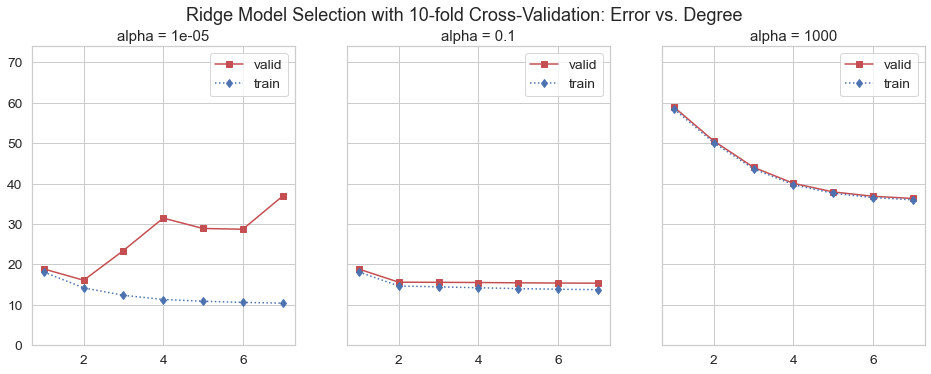

In [59]:
fig, ax_grid = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(16, 5.5))

for aa, alpha in enumerate([0.00001, 0.1, 1000.0]):
    # Find the elements of the param list that correspond to setting alpha to specific value
    match_ids = [pp for pp in range(len(ridge_param_list)) if np.allclose(alpha, ridge_param_list[pp]['alpha'])]
    
    train_err = np.asarray(ridge_cv_err_tr_list)[match_ids]
    test_err = np.asarray(ridge_cv_err_va_list)[match_ids]
    
    
    # Select which panel (of the 3 in figure) to be current active axis
    cur_ax = ax_grid[aa]
    plt.sca(cur_ax);
    
    # Set the title of the active axis
    cur_ax.set_title('alpha = %.5g' % alpha)

    # Draw line plot in active axis
    plot_train_and_valid_error_vs_degree(degree_list, train_err, test_err)

plt.suptitle('Ridge Model Selection with 10-fold Cross-Validation: Error vs. Degree');
plt.savefig('figure3-3_panels_by_alpha-err_vs_degree-seed=%d.pdf' % SEED, pad_inches=0, bbox_inches='tight')

### Prediction 3: Score on the test set using the chosen model


In [62]:
chosen_ridge_pipeline = make_poly_ridge_regr_pipeline(degree=7, alpha=0.1)
chosen_ridge_pipeline.fit(x_trva_LF, y_trva_L)
yhat_test_ridge = chosen_ridge_pipeline.predict(x_te_PF)
err_test = calc_mean_squared_error(y_te_P, yhat_test_ridge) # TODO fixme
rmse = np.sqrt(err_test)
print("RMSE: ", rmse)


RMSE:  3.816826761080241


In [36]:
print("Selected Parameters (alpha and degree):")
print("Degree 7 and Alpha 0.1)
print("10-fold CV estimate of heldout error:")
print(np.asarray(ridge_cv_err_va_list)[83])
print("Error on the test-set:")
print(err_test)

Selected Parameters (alpha and degree):
Degree 7 and:  [-2.72313524e+01 -1.02739706e+01  7.21036337e+00 -9.50264606e+00
 -2.69059738e+00 -3.87673831e+00  8.09600894e+00  4.81598256e+00
 -3.18554939e+00  6.34551145e-01 -5.11895811e-01 -6.65232663e+00
 -9.44807582e+00 -3.81860463e+00  2.99846947e+00  1.77436027e+00
  6.43073363e+00  3.98029226e+00  1.01300794e+00  4.03578656e+00
  3.31244381e+00  4.29324440e+00  1.58379122e+00  1.54145917e+00
 -3.24280069e-01  2.03408267e-01  6.90895840e-01 -9.12450319e-01
 -1.41168037e+00  5.16954890e-02 -5.13314696e+00 -4.97066818e+00
 -2.37430659e+00 -9.67300457e-02  2.46220193e+00  1.46273635e+00
  3.26906934e+00  2.23363941e+00  1.26912759e+00  2.35387219e+00
  1.88713141e+00  2.54292615e+00  1.26955182e+00  9.80305684e-01
  1.11834148e+00  1.84878859e+00  1.84683569e+00  1.75575656e+00
  1.23481692e+00  1.12030527e+00  4.94351872e-01 -3.27085419e-01
 -1.45002755e-01  8.08278926e-02 -1.16508911e-01 -2.09253337e-01
  2.91853495e-01 -2.57413882e-01 -8

In [10]:
#baseline RMSE 
#calc mean y value of train
y_hat_mean = np.mean(y_tr_M)
y_hat_base = np.full(y_te_P.shape[0], y_hat_mean)

err_test = calc_mean_squared_error(y_te_P, y_hat_base) # TODO fixme
rmse = np.sqrt(err_test)
print("RMSE: ", rmse)

RMSE:  7.104481090304907
